In [1]:
from pyiron_atomistics import Project
import numpy as np
import matplotlib.pylab as plt
%config InlineBackend.figure_format = 'retina'

# Determine thermal expansion of iron

In [2]:
from pyiron_atomistics.atomistics.master.parallel import AtomisticParallelMaster
from pyiron_base import JobGenerator


class MyJobGenerator(JobGenerator):
    @property
    def parameter_list(self):
        """
        Create list of parameters to be distributed to jobs.
        
        Returns:
            temperatures (numpy.ndarray): Array of temperature values
        """
        return np.linspace(
            self._master.input["min_temperature"],
            self._master.input["max_temperature"],
            int(self._master.input["num_points"]),
        )

    def modify_job(self, job, parameter):
        """
        Modify job properties for each of the jobs. The jobs are passed automatically inside pyiron

        Args:
            job (pyiron job): Child job
            parameter (anything): Parameter (in this example ONE temperature value)
        """
        if parameter == 0:
            job.calc_minimize(pressure=[0, 0, 0])
        else:
            job.calc_md(temperature=parameter, langevin=True, n_ionic_steps=10000, pressure=[0, 0, 0])
        return job


class ThermalExpansion(AtomisticParallelMaster):
    def __init__(self, *args, **argv):
        super().__init__(*args, **argv)
        self.input['min_temperature'] = 0
        self.input['max_temperature'] = 1000
        self.input['num_points'] = 11
        self._job_generator = MyJobGenerator(self)
        
    def collect_output(self):
        v_lst, T_lst = [], []
        for job_id in self.child_ids:
            job = pr.load(job_id)
            T_lst.append(np.mean(job['output/generic/temperature'][-10:]))
            v_lst.append(np.mean(job['output/generic/volume'][-10:]) / len(job.structure))
        with self.project_hdf5.open("output") as hdf5_out:
            hdf5_out['temperature'] = T_lst
            hdf5_out['volume'] = v_lst

In [3]:
pr = Project('MASTER')

In [4]:
potential = '2006--Lee-B-J--Fe-C--LAMMPS--ipr1'

In [5]:
lmp = pr.create.job.Lammps('lmp')
lmp.structure = pr.create.structure.bulk('Fe', cubic=True).repeat(4)
lmp.potential = potential

In [6]:
therm = pr.create_job(ThermalExpansion, 'therm')
therm.ref_job = lmp

In [7]:
therm.run()

The job therm was saved and received the ID: 3
The job lmp_0 was saved and received the ID: 4
The job lmp_1 was saved and received the ID: 5
The job lmp_2 was saved and received the ID: 6
The job lmp_3 was saved and received the ID: 7
The job lmp_4 was saved and received the ID: 8
The job lmp_5 was saved and received the ID: 9
The job lmp_6 was saved and received the ID: 10
The job lmp_7 was saved and received the ID: 11
The job lmp_8 was saved and received the ID: 12
The job lmp_9 was saved and received the ID: 13
The job lmp_10 was saved and received the ID: 14


In [8]:
therm.collect_output()

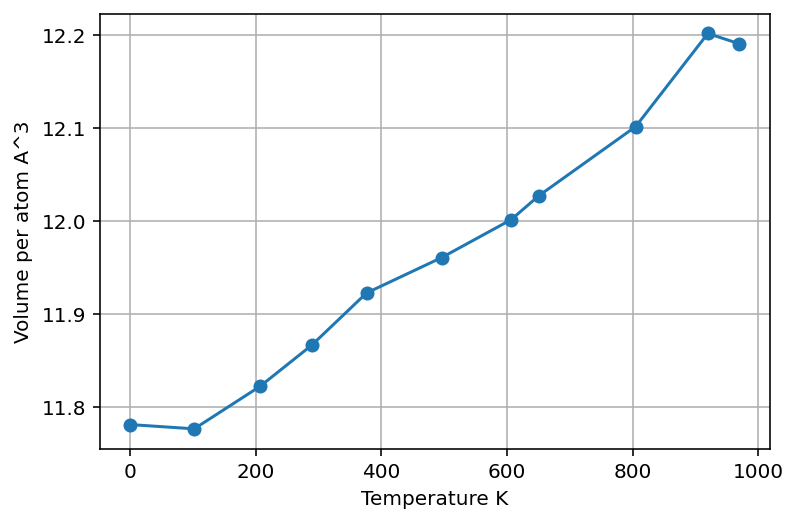

In [9]:
plt.xlabel('Temperature K')
plt.ylabel('Volume per atom A^3')
plt.grid()
plt.plot(therm['output/temperature'], therm['output/volume'], '-o')

# Determine diffusion barrier of C in Fe

In [10]:
bulk = pr.create.structure.bulk('Fe', cubic=True)
lattice_constant = bulk.cell[0, 0]

# Carbon initial and final positions
x_0 = np.array([0, 0, 1]) * lattice_constant / 2
x_1 = np.array([0, 1, 1]) * lattice_constant / 2

# Function to get FeC structure for a given C positions
def get_FeC(x_C, n_repeat=5, bulk=bulk):
    return bulk.repeat(5) + pr.create.structure.atoms(
        positions=[x_C], elements=['C']
    )

In [11]:
E_lst = []
n_measurements = 11
for r in np.linspace(0, 1, n_measurements):
    lmp = pr.create.job.Lammps('lmp_diffusion', delete_existing_job=True)
    lmp.structure = get_FeC(x_0 * (1 - r) + x_1 * r)
    lmp.structure.add_tag(selective_dynamics=[True, False, True])
    lmp.potential = potential
    lmp.calc_minimize()
    lmp.run()
    E_lst.append(lmp.output.energy_pot[-1])

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyiron_atomistics/atomistics/structure/atoms.py:1896: UserWarning: You are adding structures with different cell shapes. Taking the cell and pbc of the first structure:Cell([14.350000000000001, 14.350000000000001, 14.350000000000001])
  "Taking the cell and pbc of the first structure:{}".format(self.cell))


The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15
The job lmp_diffusion was saved and received the ID: 15


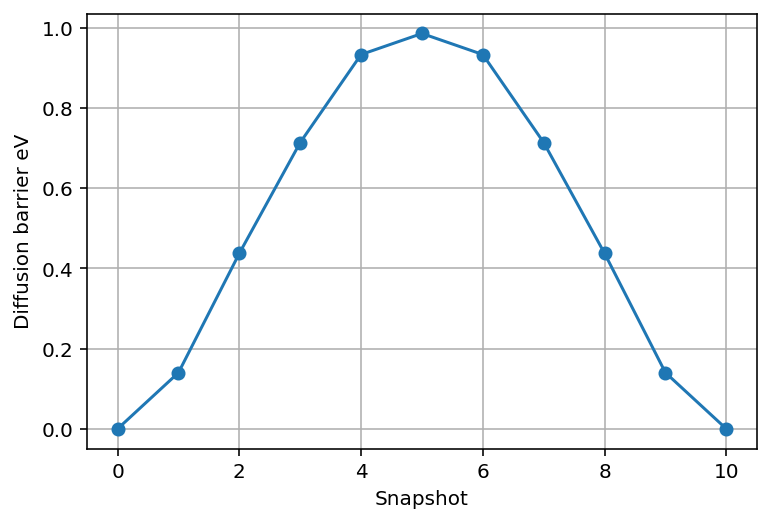

In [12]:
plt.grid()
plt.ylabel('Diffusion barrier eV')
plt.xlabel('Snapshot')
plt.plot(E_lst - np.min(E_lst), '-o')

# Exercise: write Master job for C diffusion